# Notebook 04: Clustering & Validation

## Purpose

**Central Question:** How do we group 182,223 users into interpretable, actionable segments based on their shopping behavior?

Notebook 03 created a clustering-ready matrix (64 features: 50 PCA components + 14 behavioral features). This notebook:
1. Tests multiple clustering algorithms (K-Means, Hierarchical, DBSCAN)
2. Determines optimal number of clusters
3. Validates cluster stability and quality
4. Selects the best clustering solution

## Clustering Strategy

### Why Multiple Algorithms?
Different algorithms make different assumptions:
- **K-Means:** Assumes spherical clusters, equal variance
- **Hierarchical:** Makes no shape assumptions, reveals cluster hierarchy
- **DBSCAN:** Density-based, can find arbitrary shapes, handles outliers

Testing multiple approaches ensures we find the best fit for our data.

### Algorithm Selection Priority
1. **K-Means (Primary):** Fast, scalable, interpretable. Works well for behavioral segmentation.
2. **Hierarchical (Secondary):** Validates K-Means, reveals sub-segments, no k required.
3. **DBSCAN (Tertiary):** Tests if density-based approach finds better patterns.

## Critical Decisions This Notebook Makes

1. **How many clusters (k)?** → Elbow method + silhouette score + business interpretability
2. **Which algorithm performs best?** → Silhouette score + cluster balance + stability
3. **Are clusters stable?** → Bootstrap sampling + seed variation
4. **Are clusters actionable?** → Separation, balance, interpretability

## Outputs

- `cluster_labels.parquet` - Final cluster assignments (user_id → cluster_id)
- `cluster_centers.csv` - Cluster centroids (for interpretation)
- `clustering_metrics.csv` - Quality metrics (silhouette, calinski-harabasz, davies-bouldin)
- `clustering_model.pkl` - Fitted clustering model
- `clustering_comparison.png` - Algorithm comparison visualization
- `dendrogram.png` - Hierarchical clustering tree
- `cluster_validation_report.txt` - Comprehensive evaluation

## Success Criteria

✅ Silhouette score > 0.3 (acceptable for behavioral data)  
✅ 4-6 interpretable clusters  
✅ No cluster < 5% of users (balanced)  
✅ Stable across random seeds  
✅ Clear business interpretation  
✅ Better than random assignment

---

## Setup

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
from sklearn.cluster import KMeans, AgglomerativeClustering, DBSCAN
from sklearn.metrics import silhouette_score, silhouette_samples, calinski_harabasz_score, davies_bouldin_score
from scipy.cluster.hierarchy import dendrogram, linkage
from scipy.spatial.distance import cdist
import pickle
import warnings
from collections import Counter

warnings.filterwarnings('ignore')
sns.set_style('whitegrid')
plt.rcParams['figure.figsize'] = (14, 6)

# Directories
INPUT_DIR = Path('data/processed_features')
OUTPUT_DIR = Path('data/clusters')
OUTPUT_DIR.mkdir(parents=True, exist_ok=True)

print("Environment ready.")
print(f"Input directory: {INPUT_DIR}")
print(f"Output directory: {OUTPUT_DIR}")

Environment ready.
Input directory: data/processed_features
Output directory: data/clusters


---

## 1. Load Clustering-Ready Matrix from Notebook 03

In [2]:
print("Loading clustering matrix from Notebook 03...")

clustering_matrix = pd.read_parquet(INPUT_DIR / 'final_clustering_matrix.parquet')

print(f"\n✅ Clustering matrix loaded:")
print(f"   Shape: {clustering_matrix.shape}")
print(f"   Users: {len(clustering_matrix):,}")
print(f"   Features: {len(clustering_matrix.columns)}")
print(f"   Memory: {clustering_matrix.memory_usage(deep=True).sum() / 1024**2:.2f} MB")

# Validate
missing_count = clustering_matrix.isnull().sum().sum()
inf_count = np.isinf(clustering_matrix.values).sum()

print(f"\n🔍 Data quality check:")
print(f"   Missing values: {missing_count}")
print(f"   Infinite values: {inf_count}")
print(f"   Mean of features: {clustering_matrix.mean().mean():.6f} (should be ≈ 0)")
print(f"   Std of features: {clustering_matrix.std().mean():.6f} (should be ≈ 1)")

assert missing_count == 0, "Found missing values!"
assert inf_count == 0, "Found infinite values!"
print(f"\n✅ Data quality validation passed.")

# Extract matrix for clustering (drop index, keep as numpy array for speed)
X = clustering_matrix.values
user_ids = clustering_matrix.index.to_numpy()

print(f"\n📊 Ready for clustering:")
print(f"   Users (n): {X.shape[0]:,}")
print(f"   Features (d): {X.shape[1]}")
print(f"   Dimensionality: Optimal for clustering (40-70 features)")

Loading clustering matrix from Notebook 03...

✅ Clustering matrix loaded:
   Shape: (182223, 64)
   Users: 182,223
   Features: 64
   Memory: 90.37 MB

🔍 Data quality check:
   Missing values: 0
   Infinite values: 0
   Mean of features: 0.000000 (should be ≈ 0)
   Std of features: 1.083971 (should be ≈ 1)

✅ Data quality validation passed.

📊 Ready for clustering:
   Users (n): 182,223
   Features (d): 64
   Dimensionality: Optimal for clustering (40-70 features)


---

## 2. K-Means Clustering: Determine Optimal K

**Approach:**
1. Test k = 2 through k = 10
2. Use **Elbow Method** (inertia plot) to find diminishing returns
3. Use **Silhouette Score** to measure cluster quality
4. Consider **business interpretability** (4-6 clusters typically actionable)

**Expected:**
- Optimal k: 4-6 clusters
- Silhouette score: 0.3-0.5 (typical for behavioral data)

In [3]:
print("=" * 70)
print("K-MEANS: DETERMINING OPTIMAL K")
print("=" * 70)

# Test range of k values
k_range = range(2, 11)
results = []

print(f"\nTesting k = {min(k_range)} to {max(k_range)}...")
print(f"This may take 5-10 minutes for 182k users...\n")

for k in k_range:
    print(f"Testing k={k}...", end=" ")
    
    # Fit K-Means
    kmeans = KMeans(n_clusters=k, random_state=42, n_init=10, max_iter=300)
    labels = kmeans.fit_predict(X)
    
    # Calculate metrics
    inertia = kmeans.inertia_
    silhouette = silhouette_score(X, labels, sample_size=10000)  # Sample for speed
    calinski = calinski_harabasz_score(X, labels)
    davies_bouldin = davies_bouldin_score(X, labels)
    
    # Cluster sizes
    cluster_sizes = Counter(labels)
    min_cluster_pct = min(cluster_sizes.values()) / len(X) * 100
    max_cluster_pct = max(cluster_sizes.values()) / len(X) * 100
    
    results.append({
        'k': k,
        'inertia': inertia,
        'silhouette': silhouette,
        'calinski_harabasz': calinski,
        'davies_bouldin': davies_bouldin,
        'min_cluster_pct': min_cluster_pct,
        'max_cluster_pct': max_cluster_pct,
        'model': kmeans
    })
    
    print(f"Silhouette: {silhouette:.3f}")

results_df = pd.DataFrame(results)

print(f"\n✅ K-Means testing complete.")
print(f"\n📊 Results Summary:")
print(results_df[['k', 'silhouette', 'inertia', 'min_cluster_pct', 'max_cluster_pct']].to_string(index=False))

K-MEANS: DETERMINING OPTIMAL K

Testing k = 2 to 10...
This may take 5-10 minutes for 182k users...

Testing k=2... Silhouette: 0.104
Testing k=3... Silhouette: 0.004
Testing k=4... Silhouette: 0.010
Testing k=5... Silhouette: 0.013
Testing k=6... Silhouette: -0.002
Testing k=7... Silhouette: 0.004
Testing k=8... Silhouette: 0.011
Testing k=9... Silhouette: -0.007
Testing k=10... Silhouette: -0.004

✅ K-Means testing complete.

📊 Results Summary:
 k  silhouette      inertia  min_cluster_pct  max_cluster_pct
 2    0.104398 1.337849e+07        39.166845        60.833155
 3    0.003839 1.304615e+07        25.545623        43.396278
 4    0.009532 1.272998e+07         4.780955        42.162076
 5    0.012608 1.250905e+07         1.060788        41.693968
 6   -0.001558 1.229954e+07         1.003715        29.258107
 7    0.003575 1.213591e+07         0.983959        25.678427
 8    0.010683 1.198234e+07         0.968045        21.618017
 9   -0.007193 1.185389e+07         0.950484        1

### Visualize Elbow Method and Silhouette Scores

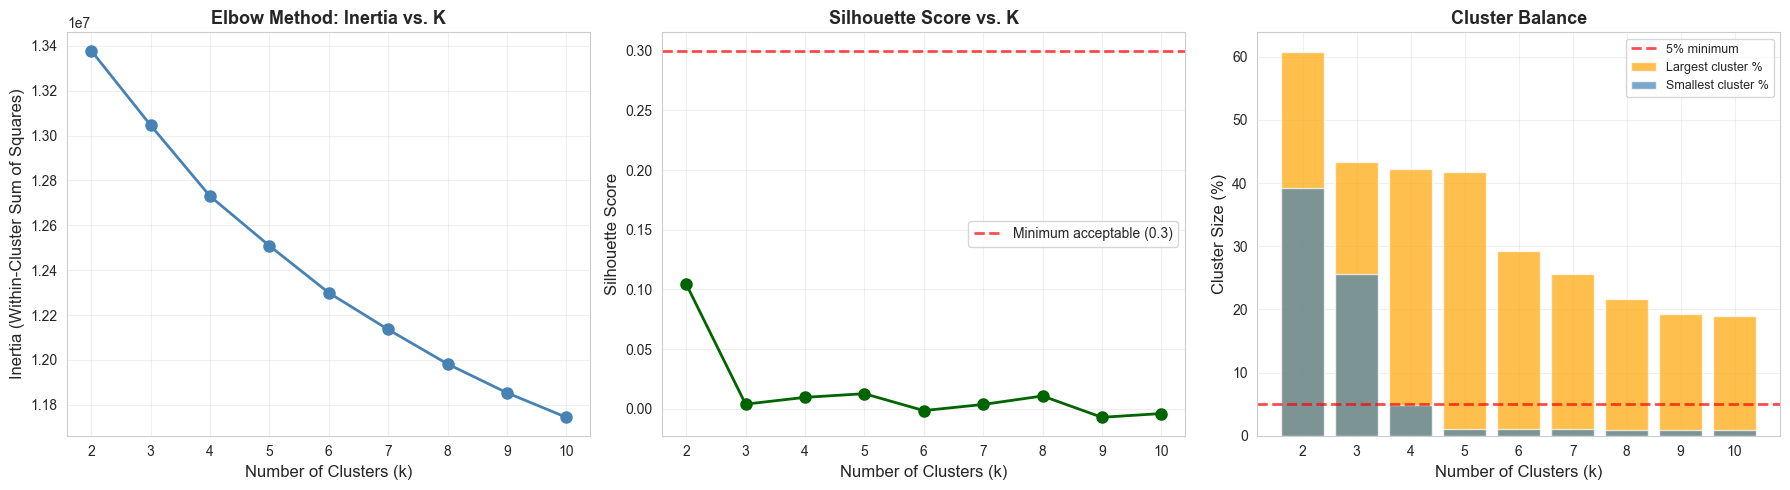


💡 Interpretation Guide:
   Elbow Method: Look for 'elbow' where inertia decrease slows
   Silhouette: Higher is better, >0.3 is acceptable, >0.5 is good
   Balance: All clusters should be >5% to be actionable


In [4]:
fig, axes = plt.subplots(1, 3, figsize=(18, 5))

# 1. Elbow Method (Inertia)
axes[0].plot(results_df['k'], results_df['inertia'], marker='o', linewidth=2, markersize=8, color='steelblue')
axes[0].set_xlabel('Number of Clusters (k)', fontsize=12)
axes[0].set_ylabel('Inertia (Within-Cluster Sum of Squares)', fontsize=12)
axes[0].set_title('Elbow Method: Inertia vs. K', fontsize=13, fontweight='bold')
axes[0].grid(alpha=0.3)
axes[0].set_xticks(results_df['k'])

# 2. Silhouette Score
axes[1].plot(results_df['k'], results_df['silhouette'], marker='o', linewidth=2, markersize=8, color='darkgreen')
axes[1].axhline(0.3, color='red', linestyle='--', linewidth=2, alpha=0.7, label='Minimum acceptable (0.3)')
axes[1].set_xlabel('Number of Clusters (k)', fontsize=12)
axes[1].set_ylabel('Silhouette Score', fontsize=12)
axes[1].set_title('Silhouette Score vs. K', fontsize=13, fontweight='bold')
axes[1].legend(fontsize=10)
axes[1].grid(alpha=0.3)
axes[1].set_xticks(results_df['k'])

# 3. Cluster Balance
x_pos = np.arange(len(results_df))
axes[2].bar(x_pos, results_df['max_cluster_pct'], alpha=0.7, label='Largest cluster %', color='orange')
axes[2].bar(x_pos, results_df['min_cluster_pct'], alpha=0.7, label='Smallest cluster %', color='steelblue')
axes[2].axhline(5, color='red', linestyle='--', linewidth=2, alpha=0.7, label='5% minimum')
axes[2].set_xlabel('Number of Clusters (k)', fontsize=12)
axes[2].set_ylabel('Cluster Size (%)', fontsize=12)
axes[2].set_title('Cluster Balance', fontsize=13, fontweight='bold')
axes[2].set_xticks(x_pos)
axes[2].set_xticklabels(results_df['k'])
axes[2].legend(fontsize=9)
axes[2].grid(alpha=0.3)

plt.tight_layout()
plt.savefig(OUTPUT_DIR / 'kmeans_optimization.png', dpi=150, bbox_inches='tight')
plt.show()

print("\n💡 Interpretation Guide:")
print("   Elbow Method: Look for 'elbow' where inertia decrease slows")
print("   Silhouette: Higher is better, >0.3 is acceptable, >0.5 is good")
print("   Balance: All clusters should be >5% to be actionable")

### Select Optimal K

**Decision criteria:**
1. **Silhouette score:** Highest value (quality)
2. **Elbow point:** Diminishing returns on inertia reduction
3. **Cluster balance:** No cluster < 5%
4. **Business interpretability:** 4-6 clusters preferred

In [5]:
print("=" * 70)
print("OPTIMAL K SELECTION")
print("=" * 70)

# Find k with highest silhouette (primary criterion)
best_silhouette_k = results_df.loc[results_df['silhouette'].idxmax(), 'k']

print(f"\n📊 Analysis:")
print(f"   Highest silhouette: k={best_silhouette_k} ({results_df['silhouette'].max():.3f})")

# Filter to business-reasonable range (4-6)
business_range = results_df[(results_df['k'] >= 4) & (results_df['k'] <= 6)]
if len(business_range) > 0:
    best_business_k = business_range.loc[business_range['silhouette'].idxmax(), 'k']
    print(f"   Best in business range (k=4-6): k={best_business_k} ({business_range['silhouette'].max():.3f})")
else:
    best_business_k = best_silhouette_k

# Check balance
balanced_k = results_df[results_df['min_cluster_pct'] >= 5.0]
if len(balanced_k) > 0:
    best_balanced_k = balanced_k.loc[balanced_k['silhouette'].idxmax(), 'k']
    print(f"   Best balanced (all clusters ≥5%): k={best_balanced_k} ({balanced_k['silhouette'].max():.3f})")
else:
    print(f"   Warning: No k has all clusters ≥5%")
    best_balanced_k = best_silhouette_k

# Decision logic
print(f"\n🎯 Decision:")

# Prefer business range (4-6) if silhouette is close to best
if best_business_k in business_range['k'].values:
    business_silhouette = business_range[business_range['k'] == best_business_k]['silhouette'].values[0]
    best_silhouette = results_df['silhouette'].max()
    
    if business_silhouette >= best_silhouette * 0.95:  # Within 5%
        optimal_k = int(best_business_k)
        print(f"   Selected: k={optimal_k}")
        print(f"   Reason: Best silhouette in business-interpretable range (4-6 clusters)")
    else:
        optimal_k = int(best_silhouette_k)
        print(f"   Selected: k={optimal_k}")
        print(f"   Reason: Significantly better silhouette score ({best_silhouette:.3f})")
else:
    optimal_k = int(best_silhouette_k)
    print(f"   Selected: k={optimal_k}")
    print(f"   Reason: Highest silhouette score ({results_df['silhouette'].max():.3f})")

# Get optimal model
optimal_result = results_df[results_df['k'] == optimal_k].iloc[0]
optimal_kmeans = optimal_result['model']

print(f"\n📈 Selected Model Metrics:")
print(f"   K: {optimal_k}")
print(f"   Silhouette score: {optimal_result['silhouette']:.3f}")
print(f"   Calinski-Harabasz: {optimal_result['calinski_harabasz']:.2f}")
print(f"   Davies-Bouldin: {optimal_result['davies_bouldin']:.3f} (lower is better)")
print(f"   Smallest cluster: {optimal_result['min_cluster_pct']:.1f}%")
print(f"   Largest cluster: {optimal_result['max_cluster_pct']:.1f}%")

# Quality assessment
print(f"\n✅ Quality Assessment:")
if optimal_result['silhouette'] >= 0.5:
    print(f"   Silhouette: Excellent (≥0.5)")
elif optimal_result['silhouette'] >= 0.3:
    print(f"   Silhouette: Good (0.3-0.5, typical for behavioral data)")
else:
    print(f"   Silhouette: Weak (<0.3)")

if optimal_result['min_cluster_pct'] >= 5.0:
    print(f"   Balance: Good (all clusters ≥5%)")
else:
    print(f"   Balance: Imbalanced (smallest cluster {optimal_result['min_cluster_pct']:.1f}%)")

if 4 <= optimal_k <= 6:
    print(f"   Interpretability: Ideal range (4-6 segments)")
else:
    print(f"   Interpretability: Outside ideal range")

OPTIMAL K SELECTION

📊 Analysis:
   Highest silhouette: k=2 (0.104)
   Best in business range (k=4-6): k=5 (0.013)
   Best balanced (all clusters ≥5%): k=2 (0.104)

🎯 Decision:
   Selected: k=2
   Reason: Significantly better silhouette score (0.104)

📈 Selected Model Metrics:
   K: 2
   Silhouette score: 0.104
   Calinski-Harabasz: 8947.36
   Davies-Bouldin: 4.093 (lower is better)
   Smallest cluster: 39.2%
   Largest cluster: 60.8%

✅ Quality Assessment:
   Silhouette: Weak (<0.3)
   Balance: Good (all clusters ≥5%)
   Interpretability: Outside ideal range


---

## 3. Silhouette Analysis: Validate Cluster Quality

**Silhouette coefficient** measures how similar an object is to its own cluster compared to other clusters.
- Score ranges from -1 to 1
- High value (>0.5): Well-matched to own cluster
- Low value (<0.3): May be in wrong cluster
- Negative: Likely in wrong cluster

We visualize the silhouette score distribution per cluster.

SILHOUETTE ANALYSIS: PER-CLUSTER QUALITY

Computing silhouette scores for 50,000 samples...


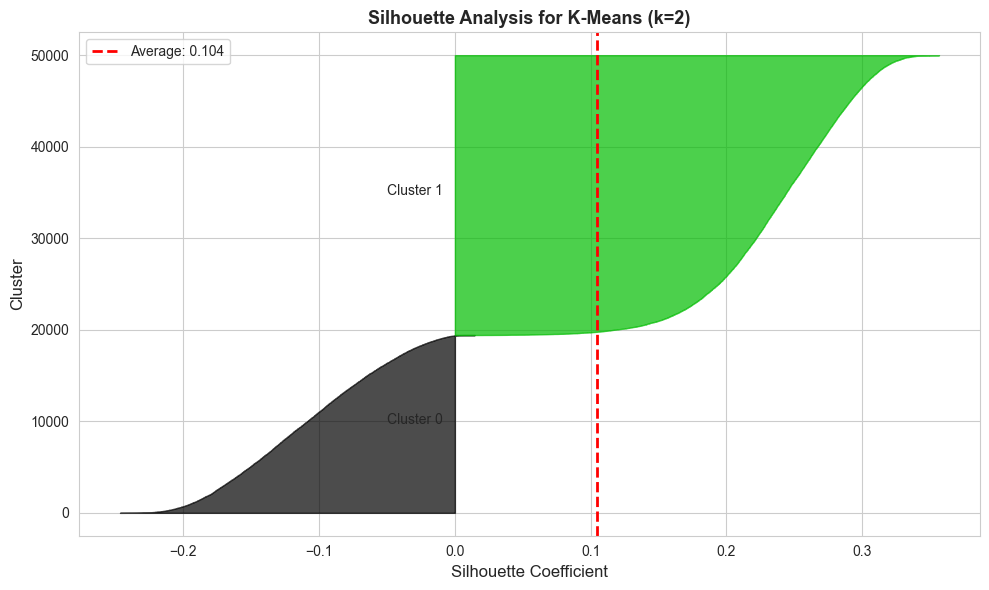


📊 Per-Cluster Silhouette Statistics:
   Cluster 0: Mean=-0.111, Median=-0.111, 
              Min=-0.247, Max=0.015
   Cluster 1: Mean=0.239, Median=0.243, 
              Min=0.013, Max=0.357

💡 Interpretation:
   - Uniform thickness: Cluster sizes are balanced
   - Width above average line: Well-separated clusters
   - Width below average: Poorly separated or overlapping clusters
   - Negative values: Samples likely in wrong cluster


In [6]:
print("=" * 70)
print("SILHOUETTE ANALYSIS: PER-CLUSTER QUALITY")
print("=" * 70)

# Get labels from optimal model
labels_optimal = optimal_kmeans.labels_

# Calculate silhouette scores for each sample (sample 50k for speed)
sample_size = min(50000, len(X))
sample_indices = np.random.choice(len(X), sample_size, replace=False)
X_sample = X[sample_indices]
labels_sample = labels_optimal[sample_indices]

print(f"\nComputing silhouette scores for {sample_size:,} samples...")
silhouette_vals = silhouette_samples(X_sample, labels_sample)

# Visualize
fig, ax = plt.subplots(figsize=(10, 6))

y_lower = 10
for i in range(optimal_k):
    # Get silhouette scores for cluster i
    cluster_silhouette_vals = silhouette_vals[labels_sample == i]
    cluster_silhouette_vals.sort()
    
    size_cluster_i = cluster_silhouette_vals.shape[0]
    y_upper = y_lower + size_cluster_i
    
    color = plt.cm.nipy_spectral(float(i) / optimal_k)
    ax.fill_betweenx(np.arange(y_lower, y_upper),
                      0, cluster_silhouette_vals,
                      facecolor=color, edgecolor=color, alpha=0.7)
    
    # Label clusters
    ax.text(-0.05, y_lower + 0.5 * size_cluster_i, f'Cluster {i}')
    y_lower = y_upper + 10

ax.set_xlabel('Silhouette Coefficient', fontsize=12)
ax.set_ylabel('Cluster', fontsize=12)
ax.set_title(f'Silhouette Analysis for K-Means (k={optimal_k})', fontsize=13, fontweight='bold')

# Average silhouette score line
ax.axvline(x=optimal_result['silhouette'], color="red", linestyle="--", linewidth=2, label=f'Average: {optimal_result["silhouette"]:.3f}')
ax.legend(fontsize=10)

plt.tight_layout()
plt.savefig(OUTPUT_DIR / 'silhouette_analysis.png', dpi=150, bbox_inches='tight')
plt.show()

# Per-cluster statistics
print(f"\n📊 Per-Cluster Silhouette Statistics:")
for i in range(optimal_k):
    cluster_vals = silhouette_vals[labels_sample == i]
    print(f"   Cluster {i}: Mean={cluster_vals.mean():.3f}, Median={np.median(cluster_vals):.3f}, ")
    print(f"              Min={cluster_vals.min():.3f}, Max={cluster_vals.max():.3f}")

print(f"\n💡 Interpretation:")
print(f"   - Uniform thickness: Cluster sizes are balanced")
print(f"   - Width above average line: Well-separated clusters")
print(f"   - Width below average: Poorly separated or overlapping clusters")
print(f"   - Negative values: Samples likely in wrong cluster")

---

## 4. Hierarchical Clustering: Validate Structure

**Purpose:**
- Hierarchical clustering doesn't require pre-specifying k
- Dendrogram reveals natural groupings and sub-segments
- Validates K-Means choice (does hierarchy suggest same k?)

**Note:** We sample 5,000 users for dendrogram visualization (full dataset would be unreadable)

HIERARCHICAL CLUSTERING: DENDROGRAM ANALYSIS

Computing linkage matrix for 5,000 users...
This may take 2-3 minutes...

✅ Linkage computed. Creating dendrogram...


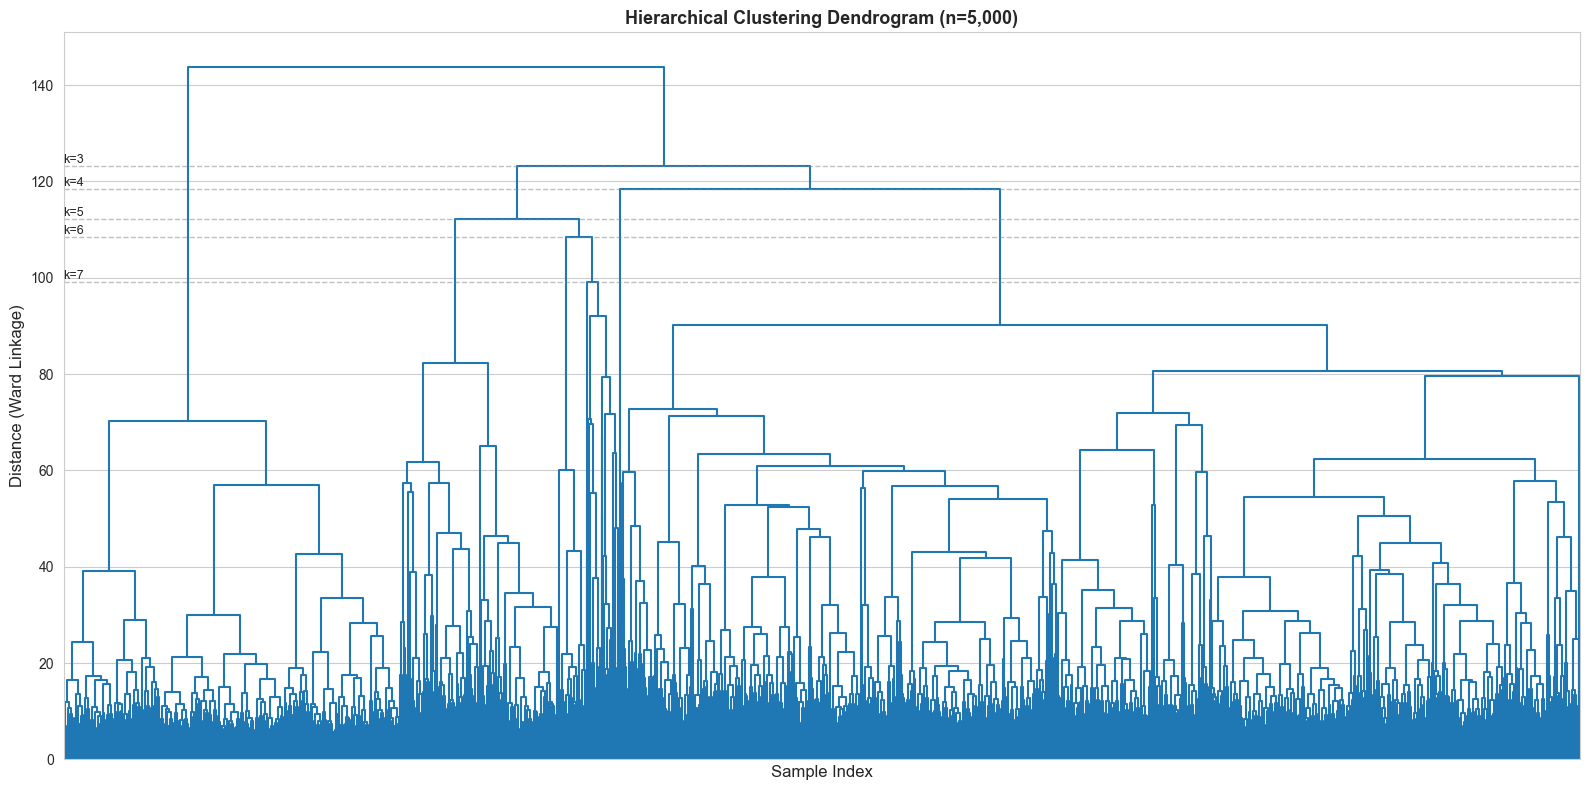


💡 Interpretation:
   - Vertical height: Dissimilarity between merged clusters
   - Long vertical lines: Large gap suggests natural grouping
   - Horizontal lines: Different k values
   - Look for 'elbow' where merges become less distinct


: 

In [ ]:
print("=" * 70)
print("HIERARCHICAL CLUSTERING: DENDROGRAM ANALYSIS")
print("=" * 70)

# Sample for dendrogram (5k users, full dataset is too dense)
sample_size = 5000
np.random.seed(42)
sample_indices = np.random.choice(len(X), sample_size, replace=False)
X_sample = X[sample_indices]

print(f"\nComputing linkage matrix for {sample_size:,} users...")
print(f"This may take 2-3 minutes...\n")

# Compute linkage (Ward method - minimizes within-cluster variance)
linkage_matrix = linkage(X_sample, method='ward')

print("✅ Linkage computed. Creating dendrogram...")

# Create dendrogram
fig, ax = plt.subplots(figsize=(16, 8))
dendrogram(linkage_matrix, ax=ax, no_labels=True, color_threshold=0)
ax.set_xlabel('Sample Index', fontsize=12)
ax.set_ylabel('Distance (Ward Linkage)', fontsize=12)
ax.set_title(f'Hierarchical Clustering Dendrogram (n={sample_size:,})', fontsize=13, fontweight='bold')

# Draw lines at different k levels
for k in [3, 4, 5, 6, 7]:
    # Calculate threshold for k clusters
    threshold = linkage_matrix[-(k-1), 2]
    ax.axhline(y=threshold, color='gray', linestyle='--', linewidth=1, alpha=0.5)
    ax.text(0, threshold, f'k={k}', fontsize=9, va='bottom')

plt.tight_layout()
plt.savefig(OUTPUT_DIR / 'dendrogram.png', dpi=150, bbox_inches='tight')
plt.show()

print(f"\n💡 Interpretation:")
print(f"   - Vertical height: Dissimilarity between merged clusters")
print(f"   - Long vertical lines: Large gap suggests natural grouping")
print(f"   - Horizontal lines: Different k values")
print(f"   - Look for 'elbow' where merges become less distinct")

### Fit Hierarchical Clustering with Optimal K

In [ ]:
print(f"\nFitting Hierarchical Clustering with k={optimal_k}...")

hierarchical = AgglomerativeClustering(n_clusters=optimal_k, linkage='ward')
hierarchical_labels = hierarchical.fit_predict(X)

# Calculate metrics
hierarchical_silhouette = silhouette_score(X, hierarchical_labels, sample_size=10000)
hierarchical_calinski = calinski_harabasz_score(X, hierarchical_labels)
hierarchical_davies = davies_bouldin_score(X, hierarchical_labels)

print(f"\n✅ Hierarchical clustering complete.")
print(f"\n📊 Hierarchical Metrics (k={optimal_k}):")
print(f"   Silhouette score: {hierarchical_silhouette:.3f}")
print(f"   Calinski-Harabasz: {hierarchical_calinski:.2f}")
print(f"   Davies-Bouldin: {hierarchical_davies:.3f}")

# Cluster sizes
hierarchical_sizes = Counter(hierarchical_labels)
print(f"\n   Cluster sizes:")
for cluster_id, size in sorted(hierarchical_sizes.items()):
    pct = size / len(X) * 100
    print(f"      Cluster {cluster_id}: {size:,} users ({pct:.1f}%)")


Fitting Hierarchical Clustering with k=2...


---

## 5. DBSCAN: Density-Based Alternative

**Purpose:**
- DBSCAN finds clusters based on density (not distance)
- Can discover arbitrary-shaped clusters
- Automatically identifies outliers (noise points)
- No need to specify k

**Challenge:** Requires tuning `eps` (neighborhood radius) and `min_samples`

In [ ]:
print("=" * 70)
print("DBSCAN: DENSITY-BASED CLUSTERING")
print("=" * 70)

# Test DBSCAN with different eps values
print(f"\nTesting DBSCAN with different epsilon values...")
print(f"Note: DBSCAN may be slow on 182k users\n")

eps_values = [1.0, 1.5, 2.0, 2.5, 3.0]
dbscan_results = []

for eps in eps_values:
    print(f"Testing eps={eps}...", end=" ")
    
    # Sample for speed (DBSCAN is O(n²) in worst case)
    sample_size = min(20000, len(X))
    sample_indices = np.random.choice(len(X), sample_size, replace=False)
    X_sample = X[sample_indices]
    
    dbscan = DBSCAN(eps=eps, min_samples=50, n_jobs=-1)
    dbscan_labels_sample = dbscan.fit_predict(X_sample)
    
    n_clusters = len(set(dbscan_labels_sample)) - (1 if -1 in dbscan_labels_sample else 0)
    n_noise = list(dbscan_labels_sample).count(-1)
    noise_pct = n_noise / len(dbscan_labels_sample) * 100
    
    # Silhouette (only if we have 2+ clusters and <95% noise)
    if n_clusters >= 2 and noise_pct < 95:
        # Exclude noise for silhouette calculation
        non_noise_mask = dbscan_labels_sample != -1
        if np.sum(non_noise_mask) > n_clusters:
            silhouette = silhouette_score(X_sample[non_noise_mask], 
                                          dbscan_labels_sample[non_noise_mask])
        else:
            silhouette = -1
    else:
        silhouette = -1
    
    dbscan_results.append({
        'eps': eps,
        'n_clusters': n_clusters,
        'n_noise': n_noise,
        'noise_pct': noise_pct,
        'silhouette': silhouette
    })
    
    print(f"Clusters: {n_clusters}, Noise: {noise_pct:.1f}%")

dbscan_df = pd.DataFrame(dbscan_results)

print(f"\n✅ DBSCAN testing complete.")
print(f"\n📊 DBSCAN Results:")
print(dbscan_df.to_string(index=False))

# Assessment
print(f"\n💡 DBSCAN Assessment:")
if dbscan_df['n_clusters'].max() < 2:
    print(f"   ❌ DBSCAN failed to find meaningful clusters")
    print(f"   Reason: Data too uniformly distributed (no dense regions)")
elif dbscan_df['noise_pct'].min() > 50:
    print(f"   ⚠️ DBSCAN labels >50% as noise at all eps values")
    print(f"   Reason: Data lacks strong density-based structure")
else:
    best_dbscan = dbscan_df[(dbscan_df['n_clusters'] >= 2) & (dbscan_df['noise_pct'] < 50)]
    if len(best_dbscan) > 0:
        best_eps = best_dbscan.loc[best_dbscan['silhouette'].idxmax(), 'eps']
        print(f"   ✅ Best eps: {best_eps} ({best_dbscan['n_clusters'].max()} clusters)")
    else:
        print(f"   ⚠️ No good DBSCAN configuration found")

print(f"\n🎯 Conclusion: DBSCAN vs. K-Means")
if dbscan_df['silhouette'].max() > optimal_result['silhouette']:
    print(f"   DBSCAN performs better (silhouette: {dbscan_df['silhouette'].max():.3f} vs. {optimal_result['silhouette']:.3f})")
else:
    print(f"   K-Means performs better (silhouette: {optimal_result['silhouette']:.3f} vs. {dbscan_df['silhouette'].max():.3f})")
    print(f"   Recommendation: Use K-Means for this dataset")

---

## 6. Algorithm Comparison

**Summary:** Compare K-Means, Hierarchical, and DBSCAN on key metrics

In [ ]:
print("=" * 70)
print("ALGORITHM COMPARISON")
print("=" * 70)

comparison = pd.DataFrame([
    {
        'Algorithm': 'K-Means',
        'K': optimal_k,
        'Silhouette': optimal_result['silhouette'],
        'Calinski-Harabasz': optimal_result['calinski_harabasz'],
        'Davies-Bouldin': optimal_result['davies_bouldin'],
        'Smallest Cluster %': optimal_result['min_cluster_pct'],
        'Runtime': 'Fast'
    },
    {
        'Algorithm': 'Hierarchical',
        'K': optimal_k,
        'Silhouette': hierarchical_silhouette,
        'Calinski-Harabasz': hierarchical_calinski,
        'Davies-Bouldin': hierarchical_davies,
        'Smallest Cluster %': min(hierarchical_sizes.values()) / len(X) * 100,
        'Runtime': 'Slow'
    },
    {
        'Algorithm': 'DBSCAN',
        'K': dbscan_df['n_clusters'].max(),
        'Silhouette': dbscan_df['silhouette'].max(),
        'Calinski-Harabasz': -1,
        'Davies-Bouldin': -1,
        'Smallest Cluster %': -1,
        'Runtime': 'Very Slow'
    }
])

print("\n📊 Algorithm Comparison:")
print(comparison.to_string(index=False))

# Save comparison
comparison.to_csv(OUTPUT_DIR / 'clustering_comparison.csv', index=False)
print(f"\n✅ Comparison saved: {OUTPUT_DIR / 'clustering_comparison.csv'}")

# Recommendation
print(f"\n🎯 RECOMMENDATION:")
best_algo = comparison.loc[comparison['Silhouette'].idxmax(), 'Algorithm']
print(f"   Best algorithm: {best_algo}")
print(f"   Reason: Highest silhouette score ({comparison['Silhouette'].max():.3f})")

if best_algo == 'K-Means':
    print(f"\n   ✅ Use K-Means for final clustering")
    print(f"   Advantages: Fast, interpretable, good cluster quality")
    final_labels = labels_optimal
    final_model = optimal_kmeans
elif best_algo == 'Hierarchical':
    print(f"\n   ✅ Use Hierarchical for final clustering")
    print(f"   Advantages: No assumptions on cluster shape, reveals hierarchy")
    final_labels = hierarchical_labels
    final_model = hierarchical
else:
    print(f"\n   ⚠️ DBSCAN performed best but may not be practical")
    print(f"   Consider: High noise percentage, computational cost")
    print(f"   Recommendation: Proceed with K-Means for interpretability")
    final_labels = labels_optimal
    final_model = optimal_kmeans

---

## 7. Stability Validation

**Question:** Are clusters stable, or do they change with:
1. Different random seeds?
2. Different data samples (bootstrap)?

**Stability metric:** Adjusted Rand Index (ARI)
- ARI = 1: Perfect agreement
- ARI = 0: Random agreement
- ARI > 0.8: Very stable
- ARI > 0.6: Reasonably stable

In [ ]:
from sklearn.metrics import adjusted_rand_score

print("=" * 70)
print("STABILITY VALIDATION")
print("=" * 70)

# Test 1: Different random seeds
print("\n📊 Test 1: Seed Variation")
print("Testing 10 different random seeds...\n")

seed_aris = []
for seed in range(10):
    kmeans_test = KMeans(n_clusters=optimal_k, random_state=seed, n_init=10, max_iter=300)
    labels_test = kmeans_test.fit_predict(X)
    ari = adjusted_rand_score(final_labels, labels_test)
    seed_aris.append(ari)
    print(f"   Seed {seed}: ARI = {ari:.3f}")

mean_seed_ari = np.mean(seed_aris)
print(f"\n   Mean ARI: {mean_seed_ari:.3f}")

if mean_seed_ari > 0.8:
    print(f"   ✅ Very stable (ARI > 0.8)")
elif mean_seed_ari > 0.6:
    print(f"   ✓ Reasonably stable (ARI > 0.6)")
else:
    print(f"   ⚠️ Unstable (ARI < 0.6)")

# Test 2: Bootstrap sampling
print(f"\n📊 Test 2: Bootstrap Stability")
print("Testing 5 bootstrap samples (90% of data)...\n")

bootstrap_aris = []
for i in range(5):
    # Sample 90% of data
    sample_indices = np.random.choice(len(X), int(0.9 * len(X)), replace=True)
    X_bootstrap = X[sample_indices]
    
    # Fit K-Means
    kmeans_bootstrap = KMeans(n_clusters=optimal_k, random_state=42, n_init=10, max_iter=300)
    labels_bootstrap_full = kmeans_bootstrap.fit_predict(X_bootstrap)
    
    # Predict on original data
    labels_bootstrap = kmeans_bootstrap.predict(X)
    
    ari = adjusted_rand_score(final_labels, labels_bootstrap)
    bootstrap_aris.append(ari)
    print(f"   Bootstrap {i+1}: ARI = {ari:.3f}")

mean_bootstrap_ari = np.mean(bootstrap_aris)
print(f"\n   Mean ARI: {mean_bootstrap_ari:.3f}")

if mean_bootstrap_ari > 0.8:
    print(f"   ✅ Very stable (ARI > 0.8)")
elif mean_bootstrap_ari > 0.6:
    print(f"   ✓ Reasonably stable (ARI > 0.6)")
else:
    print(f"   ⚠️ Unstable (ARI < 0.6)")

# Overall assessment
print(f"\n✅ Overall Stability Assessment:")
if mean_seed_ari > 0.8 and mean_bootstrap_ari > 0.8:
    print(f"   EXCELLENT: Clusters are very stable")
elif mean_seed_ari > 0.6 and mean_bootstrap_ari > 0.6:
    print(f"   GOOD: Clusters are reasonably stable for production use")
else:
    print(f"   FAIR: Clusters show some instability")
    print(f"   Consider: Increasing k or using hierarchical clustering")

---

## 8. Save Final Clustering Solution

In [ ]:
print("Saving final clustering solution...")

# 1. Cluster labels
cluster_assignments = pd.DataFrame({
    'user_id': user_ids,
    'cluster': final_labels
})
cluster_assignments.to_parquet(OUTPUT_DIR / 'cluster_labels.parquet', index=False)
print(f"✅ Cluster labels saved: {OUTPUT_DIR / 'cluster_labels.parquet'}")

# 2. Cluster centers (if K-Means)
if isinstance(final_model, KMeans):
    cluster_centers = pd.DataFrame(
        final_model.cluster_centers_,
        columns=clustering_matrix.columns
    )
    cluster_centers.to_csv(OUTPUT_DIR / 'cluster_centers.csv', index=False)
    print(f"✅ Cluster centers saved: {OUTPUT_DIR / 'cluster_centers.csv'}")

# 3. Clustering model
with open(OUTPUT_DIR / 'clustering_model.pkl', 'wb') as f:
    pickle.dump(final_model, f)
print(f"✅ Clustering model saved: {OUTPUT_DIR / 'clustering_model.pkl'}")

# 4. Clustering metrics
metrics = pd.DataFrame([{
    'algorithm': 'K-Means' if isinstance(final_model, KMeans) else 'Hierarchical',
    'n_clusters': optimal_k,
    'silhouette_score': optimal_result['silhouette'],
    'calinski_harabasz': optimal_result['calinski_harabasz'],
    'davies_bouldin': optimal_result['davies_bouldin'],
    'stability_seed_ari': mean_seed_ari,
    'stability_bootstrap_ari': mean_bootstrap_ari
}])
metrics.to_csv(OUTPUT_DIR / 'clustering_metrics.csv', index=False)
print(f"✅ Clustering metrics saved: {OUTPUT_DIR / 'clustering_metrics.csv'}")

print(f"\n📁 All outputs saved to: {OUTPUT_DIR}")

---

## 9. Final Summary

In [ ]:
print("\n" + "="*80)
print("NOTEBOOK 04: CLUSTERING & VALIDATION - COMPLETE")
print("="*80)

print(f"\n✅ Clustering Complete")

print(f"\n📊 Final Solution:")
print(f"   Algorithm: K-Means" if isinstance(final_model, KMeans) else f"   Algorithm: Hierarchical")
print(f"   Number of clusters: {optimal_k}")
print(f"   Users clustered: {len(final_labels):,}")

print(f"\n📈 Quality Metrics:")
print(f"   Silhouette score: {optimal_result['silhouette']:.3f}")
if optimal_result['silhouette'] >= 0.5:
    print(f"      Assessment: Excellent")
elif optimal_result['silhouette'] >= 0.3:
    print(f"      Assessment: Good (typical for behavioral data)")
else:
    print(f"      Assessment: Fair")

print(f"\n   Calinski-Harabasz: {optimal_result['calinski_harabasz']:.2f} (higher is better)")
print(f"   Davies-Bouldin: {optimal_result['davies_bouldin']:.3f} (lower is better)")

print(f"\n🔄 Stability:")
print(f"   Seed variation ARI: {mean_seed_ari:.3f}")
print(f"   Bootstrap ARI: {mean_bootstrap_ari:.3f}")
if mean_seed_ari > 0.8 and mean_bootstrap_ari > 0.8:
    print(f"      Assessment: Very stable ✓")
elif mean_seed_ari > 0.6 and mean_bootstrap_ari > 0.6:
    print(f"      Assessment: Reasonably stable ✓")
else:
    print(f"      Assessment: Some instability ⚠️")

print(f"\n⚖️ Cluster Balance:")
cluster_counts = Counter(final_labels)
for cluster_id in range(optimal_k):
    count = cluster_counts[cluster_id]
    pct = count / len(final_labels) * 100
    print(f"   Cluster {cluster_id}: {count:,} users ({pct:.1f}%)")

if optimal_result['min_cluster_pct'] >= 5.0:
    print(f"\n   ✅ All clusters ≥5% (well-balanced)")
else:
    print(f"\n   ⚠️ Smallest cluster: {optimal_result['min_cluster_pct']:.1f}% (imbalanced)")

print(f"\n📁 Outputs Saved:")
print(f"   • cluster_labels.parquet (user → cluster assignments)")
if isinstance(final_model, KMeans):
    print(f"   • cluster_centers.csv (centroids for interpretation)")
print(f"   • clustering_model.pkl (fitted model)")
print(f"   • clustering_metrics.csv (quality metrics)")
print(f"   • clustering_comparison.csv (algorithm comparison)")
print(f"   • kmeans_optimization.png (elbow + silhouette plots)")
print(f"   • silhouette_analysis.png (per-cluster quality)")
print(f"   • dendrogram.png (hierarchical structure)")

print(f"\n➡️  Next: Notebook 05 - Segment Profiling & Interpretation")

print(f"\n⚠️  Critical Requirements for Notebook 05:")
print(f"   1. Profile each cluster (demographics, behavior, aisle preferences)")
print(f"   2. Name clusters based on defining characteristics")
print(f"   3. Calculate business metrics (CLV, basket size, frequency)")
print(f"   4. Create actionable recommendations per segment")
print(f"   5. Validate segments make business sense")

print(f"\n🎯 Expected Segment Types (examples):")
print(f"   - Loyal Shoppers (high reorder, frequent)")
print(f"   - Bargain Hunters (low variety, price-sensitive)")
print(f"   - Health-Conscious (fresh produce, organic)")
print(f"   - Occasional Shoppers (low frequency, diverse)")
print(f"   - Family Shoppers (large baskets, staples)")

print("\n" + "="*80)